## 1. DataSet import

In [2]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from prepare_datasets import *

X, y , feature_names , categorical_features, continuous_features, actionable_features= get_and_prepare_german_dataset()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [3]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 2. Model

In [4]:
# Taken from https://github.com/dylan-slack/manipulating-cfes/blob/main/train_models.py
# wanted to use this the same model as in the paper
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, return_logit=False):
        out = self.fc1(x)
        out = self.tanh1(out)
        out = self.fc2(out)
        out = self.tanh2(out)
        out = self.fc3(out)
        out = self.tanh3(out)
        out = self.fc4(out)
        return out


In [5]:
model = NeuralNetwork(X.shape[1], 200, 2)

## 3. Training

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [7]:
from sklearn.metrics import f1_score, accuracy_score

epochs = 2000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
model.to(device)

train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss = loss_fn(y_logits, y_train.long())

    f1_score_training = f1_score(
        y_true=y_train.cpu().detach().numpy(),
        y_pred=y_pred.cpu().detach().numpy()
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss = loss_fn(test_logits, y_test.long())

        f1_score_test = f1_score(
            y_true=y_test.cpu().detach().numpy(),
            y_pred=test_pred.cpu().detach().numpy()
        )

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    train_f1_scores.append(f1_score_training)
    test_f1_scores.append(f1_score_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, F1-Training: {f1_score_training:.2f}% | Test loss: {test_loss:.5f}, F1-Testing: {f1_score_test:.2f}%")

Epoch: 0 | Loss: 0.73281, F1-Training: 0.00% | Test loss: 0.69946, F1-Testing: 0.01%
Epoch: 100 | Loss: 0.58544, F1-Training: 0.82% | Test loss: 0.59896, F1-Testing: 0.83%
Epoch: 200 | Loss: 0.55948, F1-Training: 0.82% | Test loss: 0.57753, F1-Testing: 0.84%
Epoch: 300 | Loss: 0.54677, F1-Training: 0.82% | Test loss: 0.56676, F1-Testing: 0.83%
Epoch: 400 | Loss: 0.53266, F1-Training: 0.82% | Test loss: 0.56613, F1-Testing: 0.84%
Epoch: 500 | Loss: 0.51430, F1-Training: 0.83% | Test loss: 0.56703, F1-Testing: 0.84%
Epoch: 600 | Loss: 0.50041, F1-Training: 0.84% | Test loss: 0.57134, F1-Testing: 0.83%
Epoch: 700 | Loss: 0.49032, F1-Training: 0.84% | Test loss: 0.57656, F1-Testing: 0.83%
Epoch: 800 | Loss: 0.48176, F1-Training: 0.84% | Test loss: 0.57760, F1-Testing: 0.84%
Epoch: 900 | Loss: 0.47377, F1-Training: 0.84% | Test loss: 0.58479, F1-Testing: 0.83%
Epoch: 1000 | Loss: 0.46800, F1-Training: 0.85% | Test loss: 0.59469, F1-Testing: 0.82%
Epoch: 1100 | Loss: 0.46138, F1-Training: 0.

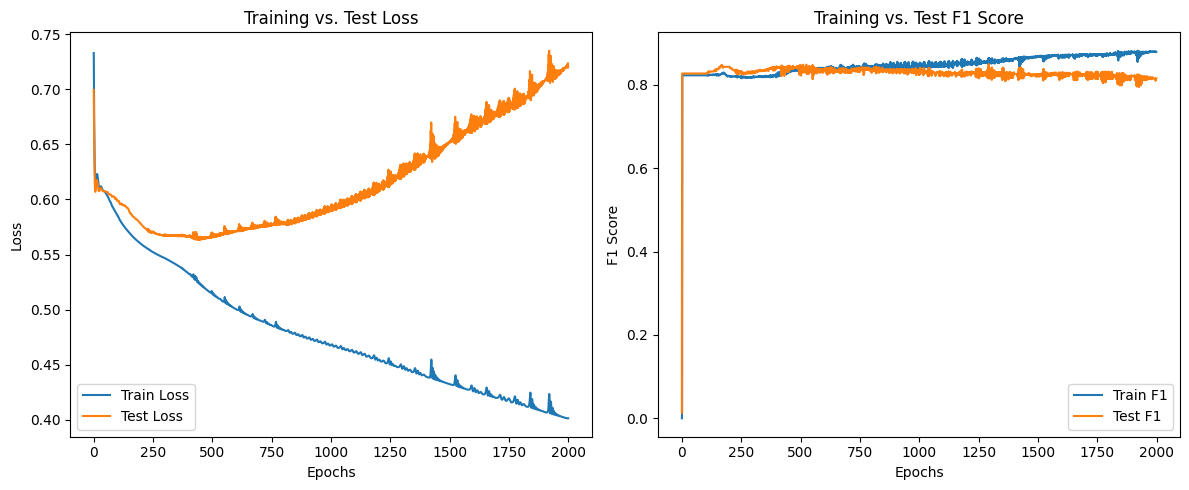

In [8]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Test Loss")
plt.legend()

# Plot F1 Score
plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label="Train F1")
plt.plot(test_f1_scores, label="Test F1")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training vs. Test F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

## 4. Counterfactual generation:
### 4.1. of one Instance

In [9]:
import dice_ml

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=continuous_features,
    categorical_features=categorical_features,
    outcome_name='target'
)

In [10]:
class PyTorchModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict_proba(self, x):
        self.model.eval()
        with torch.no_grad():
            x = x.values
            x = x.astype(np.float64)
            x_tensor = torch.FloatTensor(x)
            logits = self.model(x_tensor)
            probabilities = torch.softmax(logits, dim=1)  # Use softmax instead of sigmoid
            return probabilities.cpu().numpy()

dice_model = dice_ml.Model(
    model=PyTorchModelWrapper(model),
    backend="sklearn",
    model_type='classifier'
)

exp = dice_ml.Dice(
    dice_data,
    dice_model,
    method="genetic"
)


In [11]:

query_instance = X[11:12]
query_df = pd.DataFrame(query_instance, columns=feature_names)


#  generate counterfactuals
dice_exp = exp.generate_counterfactuals(
    query_df,
    total_CFs=1,
    desired_class="opposite",
    features_to_vary = actionable_features
)

print("\nCounterfactuals:")
dice_exp.visualize_as_dataframe(show_only_changes=True)


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Counterfactuals:
Query instance (original outcome : 0)


,Gender,ForeignWorker,Single,Age,LoanDuration,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,...,OtherLoansAtBank,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,target
0,1.0,0.0,0.0,24.0,48.0,4308.0,3.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0



Diverse Counterfactual set (new outcome: 1.0)


,Gender,ForeignWorker,Single,Age,LoanDuration,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,...,OtherLoansAtBank,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,target
0,-,-,-,-,18.0,-,-,-,-,-,...,-,-,-,1.0,0.0,-,0.0,-,-,1.0


### 4.2. calculating L1 Distance

In [12]:
# get counterfactuals as list
cf_list = dice_exp.cf_examples_list[0].final_cfs_df.values.tolist()

# Convert query_instance to tensor
if isinstance(query_instance, np.ndarray):
    query_instance = torch.from_numpy(query_instance).float()

for cf in cf_list:
    # Convert cf to tensor
    if isinstance(cf, list):
        cf = np.array(cf)
    if isinstance(cf, np.ndarray):
        cf = torch.from_numpy(cf).float()

    cf_features = cf[:-1]  # all features except the last one which is the target
    query_features = query_instance.squeeze()

    with torch.no_grad():
        # Calculate L1 distance between feature vectors
        distance = torch.norm(query_features - cf_features, p=1)
        print(f"L1 distance between query and counterfactual: {distance.item()}")

L1 distance between query and counterfactual: 106.0


## 4.3. Calculating the mean value of all L1 Distances of negatively classified instances

In [13]:
from Helper_functions import *

X_positive, X_negative, pos_indices, neg_indices = split_by_classification(model, X_test)


In [14]:
query_df = pd.DataFrame(X_negative.cpu().numpy(), columns=feature_names)

dice_exp = exp.generate_counterfactuals(
    query_df,
    total_CFs=1,
    desired_class="opposite",
    features_to_vary=actionable_features
)

100%|██████████| 44/44 [00:17<00:00,  2.49it/s]


In [15]:
l1_distances = []
for i in range(len(X_negative)):
    original = X_negative[i]
    cf_df = dice_exp.cf_examples_list[i].final_cfs_df
    cf_values = cf_df[feature_names].values
    cf_tensor = torch.from_numpy(cf_values).float().to(device)
    distance = torch.norm(original - cf_tensor, p=1).item()
    l1_distances.append(distance)

# Compute mean L1 distance
mean_l1 = np.mean(l1_distances)
print(f"Mean L1 distance for negatively classified data using DiCE: {mean_l1:.2f}")

Mean L1 distance for negatively classified data using DiCE: 734.75


## 5. Saving the model

In [16]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


## 5. Approximating the Cost of Recourse:


## 5. Modifying the Cost function:

the cost function has this formula

$$  L (X) = BinaryCrossEntropy(D {\scriptstyle train}) -  \frac{\lambda}{|D {\scriptstyle negative}|} \cdot \sum_{x \in D {\scriptstyle negative}} C(x)  $$


with C(x) is an approximation of the Cost of Recourse set to be
$$ C(x) = |G{\scriptstyle class 1} - G{\scriptstyle class 2} |$$

G being the logit of that specific class and the approximation being the difference of the logits

Calculating the counterfactuals for the negatively classified instances mutiple times during the training loop can be very costly. That justifies the use of use of an approximation

In [32]:
from sklearn.metrics import accuracy_score

lamda = 0.1
epochs = 1000

loaded_model = NeuralNetwork(X.shape[1], 200, 2)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

initial_accuracy = accuracy_score(y, torch.argmax(loaded_model(X), dim=1))
print(f"Initial Accuracy: {initial_accuracy:.2f}")

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

X_train_positive, X_train_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_train)

X_test_positive, X_test_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_test)

loss_fn_1 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=0.0001)
accuracies = []
for epoch in range(epochs):
    loaded_model.train()

    y_logits = loaded_model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss_1 = loss_fn_1(y_logits, y_train.long())

    y_logits_negative = loaded_model(X_train_negative)

    abs_differences = torch.abs (y_logits_negative[:, 0] - y_logits_negative[:, 1])
    loss_2 = torch.mean(abs_differences)
    loss = loss_1 - lamda * loss_2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loaded_model.eval()
    with torch.inference_mode():
        test_logits = loaded_model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss_1 = loss_fn_1(test_logits, y_test.long())

        y_logits_negative = loaded_model(X_test_negative)

        abs_differences = torch.abs (y_logits_negative[:, 0] - y_logits_negative[:, 1])
        test_loss_2 = torch.mean(abs_differences)

        test_loss = test_loss_1 - lamda * test_loss_2

        accuracy = accuracy_score(y_test, torch.argmax(loaded_model(X_test), dim=1))

    if epoch % 10 == 0:
        X_train_positive, X_train_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_train)

        X_test_positive, X_test_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}| Test loss: {test_loss:.5f}| Accuracy: {accuracy:.5f}")

Initial Accuracy: 0.80
Epoch: 0 | Loss: 0.25937| Test loss: 0.98718| Accuracy: 0.45333
Epoch: 100 | Loss: 0.25452| Test loss: 0.50420| Accuracy: 0.75000
Epoch: 200 | Loss: 0.23260| Test loss: 0.53324| Accuracy: 0.73667
Epoch: 300 | Loss: 0.21030| Test loss: 0.57565| Accuracy: 0.74333
Epoch: 400 | Loss: 0.18043| Test loss: 0.60044| Accuracy: 0.72000
Epoch: 500 | Loss: 0.11343| Test loss: 0.60934| Accuracy: 0.71000
Epoch: 600 | Loss: 0.06000| Test loss: 0.60312| Accuracy: 0.69667
Epoch: 700 | Loss: 0.07708| Test loss: 0.72360| Accuracy: 0.71000
Epoch: 800 | Loss: 0.03987| Test loss: 0.76823| Accuracy: 0.69667
Epoch: 900 | Loss: 0.02912| Test loss: 0.85443| Accuracy: 0.67333


## Testing for different Lamdas


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

lambdas = np.linspace(0.01, 0.4, 40)
epochs = 1000
mean_accuracies = []
mean_recourses = []

for lamda in lambdas:
    print(f"\nTraining for lambda = {lamda:.3f}")

    loaded_model = NeuralNetwork(X.shape[1], 200, 2)
    loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

    initial_accuracy = accuracy_score(y, torch.argmax(loaded_model(X), dim=1))
    print(f"Initial Accuracy: {initial_accuracy:.2f}")

    X_train_positive, X_train_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_train)

    X_test_positive, X_test_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_test)

    loss_fn_1 = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(loaded_model.parameters(), lr=0.0001)

    epoch_accuracies = []
    epoch_recourse = []

    for epoch in range(epochs):
        loaded_model.train()

        y_logits = loaded_model(X_train)
        loss_1 = loss_fn_1(y_logits, y_train.long())

        y_logits_negative = loaded_model(X_train_negative)
        abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
        loss_2 = torch.mean(abs_differences)

        loss = loss_1 - lamda * loss_2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loaded_model.eval()
        with torch.inference_mode():
            test_logits = loaded_model(X_test)
            test_loss_1 = loss_fn_1(test_logits, y_test.long())

            y_logits_negative = loaded_model(X_test_negative)
            abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
            test_loss_2 = torch.mean(abs_differences)

            test_loss = test_loss_1 - lamda * test_loss_2

            accuracy = accuracy_score(y_test, torch.argmax(test_logits, dim=1))
            epoch_accuracies.append(accuracy)
            if not torch.isnan(test_loss_2):
                epoch_recourse.append(test_loss_2.item())

        if epoch % 10 == 0:

            X_train_positive, X_train_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_train)
            X_test_positive, X_test_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_test)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f} | Accuracy: {accuracy:.5f} | Recourse loss: {test_loss_2:.5f}")

    mean_accuracy = np.mean(epoch_accuracies)
    mean_recourse = np.mean(epoch_recourse)

    mean_accuracies.append(mean_accuracy)
    mean_recourses.append(mean_recourse)

    print(f"Lambda = {lamda:.3f} | Mean Accuracy: {mean_accuracy:.4f} | Mean Recourse Loss: {mean_recourse:.4f}")



Training for lambda = 0.010
Initial Accuracy: 0.80
Epoch: 0 | Loss: 0.38458 | Test loss: 1.46308 | Accuracy: 0.45333 | Recourse loss: 5.27635
Epoch: 100 | Loss: 0.38259 | Test loss: 0.60572 | Accuracy: 0.75667 | Recourse loss: 1.56335
Epoch: 200 | Loss: 0.37885 | Test loss: 0.62265 | Accuracy: 0.76333 | Recourse loss: 1.58509
Epoch: 300 | Loss: 0.37458 | Test loss: 0.63413 | Accuracy: 0.75667 | Recourse loss: 1.64485
Epoch: 400 | Loss: 0.37004 | Test loss: 0.64642 | Accuracy: 0.75000 | Recourse loss: 1.67135
Epoch: 500 | Loss: 0.36495 | Test loss: 0.65861 | Accuracy: 0.75000 | Recourse loss: 1.69659
Epoch: 600 | Loss: 0.35964 | Test loss: 0.67177 | Accuracy: 0.75333 | Recourse loss: 1.73658
Epoch: 700 | Loss: 0.35362 | Test loss: 0.68322 | Accuracy: 0.75333 | Recourse loss: 1.79891
Epoch: 800 | Loss: 0.34802 | Test loss: 0.69324 | Accuracy: 0.75333 | Recourse loss: 1.70785
Epoch: 900 | Loss: 0.34417 | Test loss: 0.70642 | Accuracy: 0.75000 | Recourse loss: 1.63936
Lambda = 0.010 | Mea

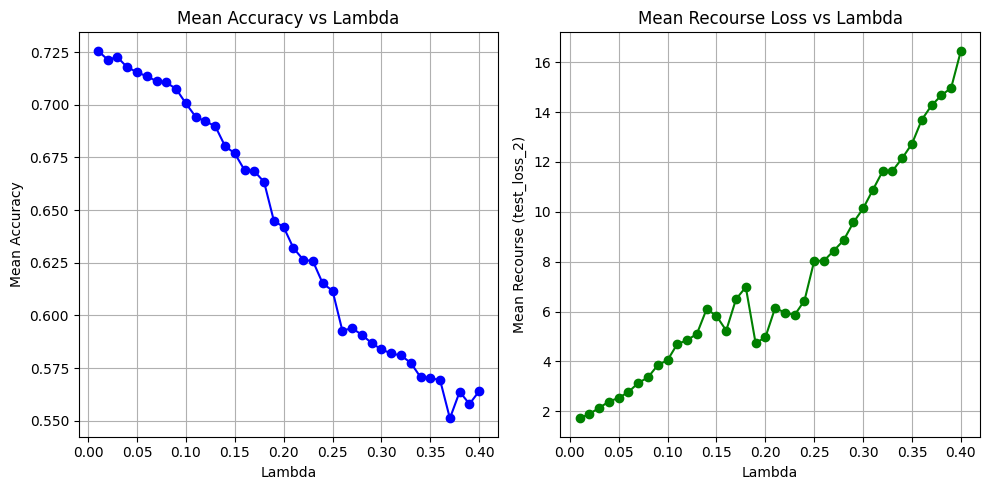

In [19]:
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(lambdas, mean_accuracies, marker='o', color='blue')
plt.title("Mean Accuracy vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Accuracy")
plt.grid(True)

# Recourse loss plot
plt.subplot(1, 2, 2)
plt.plot(lambdas, mean_recourses, marker='o', color='green')
plt.title("Mean Recourse Loss vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse (test_loss_2)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [20]:
print(mean_recourses)

[np.float64(1.7183144645094872), np.float64(1.896822252392769), np.float64(2.1338305372595787), np.float64(2.3912859981060026), np.float64(2.5377133512496948), np.float64(2.773961398243904), np.float64(3.135684098124504), np.float64(3.361435849905014), np.float64(3.851561538219452), np.float64(4.0514839173555375), np.float64(4.701395805954933), np.float64(4.851294933795929), np.float64(5.106354642629624), np.float64(6.103850613355637), np.float64(5.824741570830345), np.float64(5.238834312200546), np.float64(6.496508570551872), np.float64(6.979657728075981), np.float64(4.74287830221653), np.float64(4.960847453832626), np.float64(6.144275700569152), np.float64(5.95581119120121), np.float64(5.865950463294983), np.float64(6.4405098025798795), np.float64(8.034063711285592), np.float64(8.039004682064057), np.float64(8.442488248586654), np.float64(8.85512260735035), np.float64(9.570961337566375), np.float64(10.133238525867462), np.float64(10.882282868385316), np.float64(11.630029196858406), n

## Calculating the initial approximation of recourse because it differs slightly than the actual recourse.

In [23]:
loaded_model = NeuralNetwork(X.shape[1], 200, 2)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

X_positive, X_negative, pos_indices, neg_indices = split_by_classification(loaded_model, X)

y_logits_negative = loaded_model(X_negative)
abs_differences = torch.abs(y_logits_negative[:, 0] - y_logits_negative[:, 1])
recourse_Approximation = torch.mean(abs_differences)


print(f"initial Recourse Approximation: {recourse_Approximation:.2f}")

initial Recourse Approximation: 1.43


i think for lambda = 0.1 the results are ideal . for this lambda the mean recourse loss is 4.0515. here the recouse has doubled around 2.7 times which is a high improvement. But the accuracy took a hard hit sitting around which is not ideal Mean Accuracy: 0.7007

## Trying not to approximate the Cost of Recourse but to calculate it


In [36]:
from sklearn.metrics import accuracy_score

lamda = 0.001
epochs = 10

loaded_model = NeuralNetwork(X.shape[1], 200, 2)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

initial_accuracy = accuracy_score(y, torch.argmax(loaded_model(X), dim=1))
print(f"Initial Accuracy: {initial_accuracy:.2f}")

X_train_positive, X_train_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_train)

X_test_positive, X_test_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_test)

loss_fn_1 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=0.0001)
accuracies = []
for epoch in range(epochs):
    loaded_model.train()

    y_logits = loaded_model(X_train)
    y_pred = torch.argmax(y_logits, dim=1)
    loss_1 = loss_fn_1(y_logits, y_train.long())



    query_df = pd.DataFrame(X_train_negative.cpu().numpy(), columns=feature_names)
    dice_exp = exp.generate_counterfactuals(
        query_df,
        total_CFs=1,
        desired_class="opposite",
        features_to_vary=actionable_features
    )

    l1_distances = []
    for i in range(len(X_train_negative)):
        original = X_train_negative[i]
        cf_df = dice_exp.cf_examples_list[i].final_cfs_df

        if cf_df is None or cf_df.empty:
            continue

        cf_values = cf_df[feature_names].values
        cf_tensor = torch.from_numpy(cf_values).float().to(device)
        distance = torch.norm(original - cf_tensor, p=1).item()
        l1_distances.append(distance)


    mean_l1 = np.mean(l1_distances) ### which is basically the loss
    loss_2 = mean_l1

    loss = loss_1 - lamda * loss_2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loaded_model.eval()
    with torch.inference_mode():
        test_logits = loaded_model(X_test)
        test_pred = torch.argmax(test_logits, dim=1)
        test_loss_1 = loss_fn_1(test_logits, y_test.long())

        query_df = pd.DataFrame(X_test_negative.cpu().numpy(), columns=feature_names)
        dice_exp = exp.generate_counterfactuals(
        query_df,
        total_CFs=1,
        desired_class="opposite",
        features_to_vary=actionable_features
        )

        l1_distances = []
        for i in range(len(X_test_negative)):
            original = X_test_negative[i]
            cf_df = dice_exp.cf_examples_list[i].final_cfs_df

            if cf_df is None or cf_df.empty:
                continue

            cf_values = cf_df[feature_names].values
            cf_tensor = torch.from_numpy(cf_values).float().to(device)
            distance = torch.norm(original - cf_tensor, p=1).item()
            l1_distances.append(distance)


        test_mean_l1 = np.mean(l1_distances) ### which is basically the loss
        test_loss_2 = test_mean_l1

        test_loss = test_loss_1 - lamda * test_loss_2

        accuracy = accuracy_score(y_test, torch.argmax(loaded_model(X_test), dim=1))

    if epoch % 10 == 0 and epoch>0:
        X_train_positive, X_train_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_train)

        X_test_positive, X_test_negative, pos_indices, neg_indices = split_by_classification(loaded_model,X_test)

    print(f"Epoch: {epoch} | Loss: {loss:.5f}| Test loss: {test_loss:.5f}| Accuracy: {accuracy:.5f}")

Initial Accuracy: 0.80


100%|██████████| 67/67 [00:52<00:00,  1.28it/s]


Epoch: 0 | Loss: -1.22236| Test loss: 0.83864| Accuracy: 0.45667


 10%|▉         | 57/583 [01:09<10:38,  1.21s/it]  


KeyboardInterrupt: 

The recouse seem to be too big so that the accuracy has